#**CSC2034 Project Report - Data Science**
##**Clo Ellis 220402088**


### Google Colab Setup:

In [1]:
!git clone https://github.com/cellis1912/2034_Data.git

Cloning into '2034_Data'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (7/7), 923.72 KiB | 2.95 MiB/s, done.


In [5]:
import os
os.chdir('2034_Data')

### Import Libaries:

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from helpers import show_scatterplot
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,  accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

### All data from both tables:

In [7]:
white_data = pd.read_csv('winequality-white.csv',  delimiter=';')
red_data = pd.read_csv('winequality-red.csv',  delimiter=';')

def calculate_stats(data):
    stats = {
        'mean': data.mean(),
        'median': data.median(),
        'mode': data.mode().iloc[0],
        'std_dev': data.std(),
        'variance': data.var(),
        'min': data.min(),
        '25th_percentile': data.quantile(0.25),
        '50th_percentile': data.quantile(0.5),
        '75th_percentile': data.quantile(0.75),
        'max': data.max(),
        'skewness': data.skew(),
        'kurtosis': data.kurtosis()
    }
    return pd.DataFrame(stats)


white_stats = calculate_stats(white_data)
print("White Stats:")
print(white_stats)

red_stats = calculate_stats(red_data)
print("Red Stats:")
print(red_stats)


White Stats:
                            mean     median     mode    std_dev     variance  \
fixed acidity           6.854788    6.80000    6.800   0.843868     0.712114   
volatile acidity        0.278241    0.26000    0.280   0.100795     0.010160   
citric acid             0.334192    0.32000    0.300   0.121020     0.014646   
residual sugar          6.391415    5.20000    1.200   5.072058    25.725770   
chlorides               0.045772    0.04300    0.044   0.021848     0.000477   
free sulfur dioxide    35.308085   34.00000   29.000  17.007137   289.242720   
total sulfur dioxide  138.360657  134.00000  111.000  42.498065  1806.085491   
density                 0.994027    0.99374    0.992   0.002991     0.000009   
pH                      3.188267    3.18000    3.140   0.151001     0.022801   
sulphates               0.489847    0.47000    0.500   0.114126     0.013025   
alcohol                10.514267   10.40000    9.400   1.230621     1.514427   
quality                 5.8

### Quality Distribution
 Distribution of wine quality across all samples.


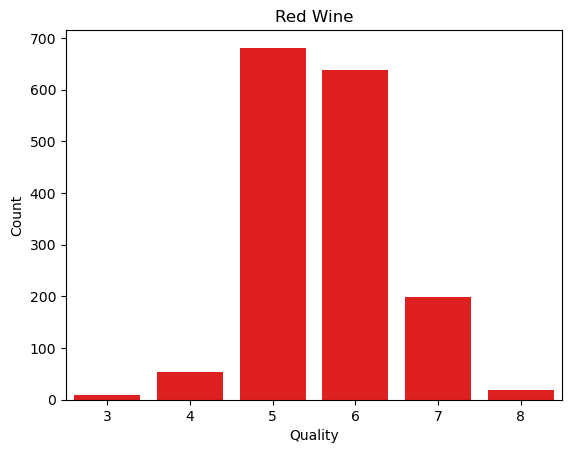

In [ ]:
sns.countplot(data=red_data, x='quality', color='red')
plt.title("Red Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

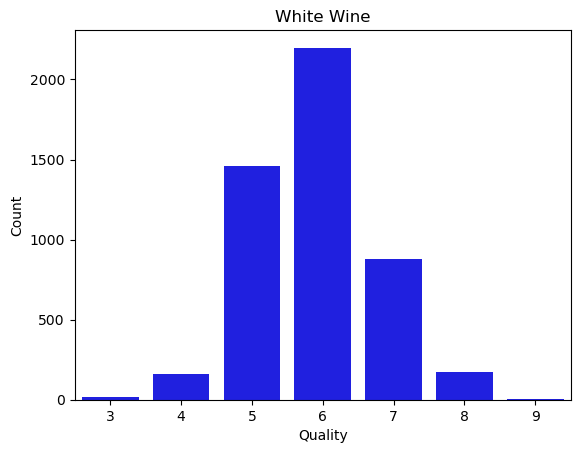

In [ ]:
sns.countplot(data=white_data, x='quality', color='blue')
plt.title("White Wine")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()
plt.close()

Distribution of wine quality across all samples combined.

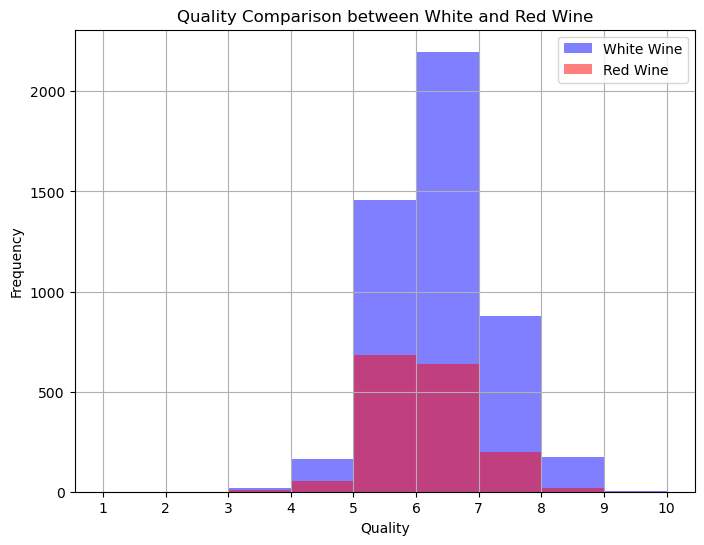

In [ ]:
# Extracting quality columns
white_quality = white_data['quality']
red_quality = red_data['quality']

# Plotting
plt.figure(figsize=(8, 6))
plt.hist(white_quality, bins=range(1, 11), alpha=0.5,
         color='blue', label='White Wine')
plt.hist(red_quality, bins=range(1, 11), alpha=0.5,
         color='red', label='Red Wine')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Quality Comparison between White and Red Wine')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.show()

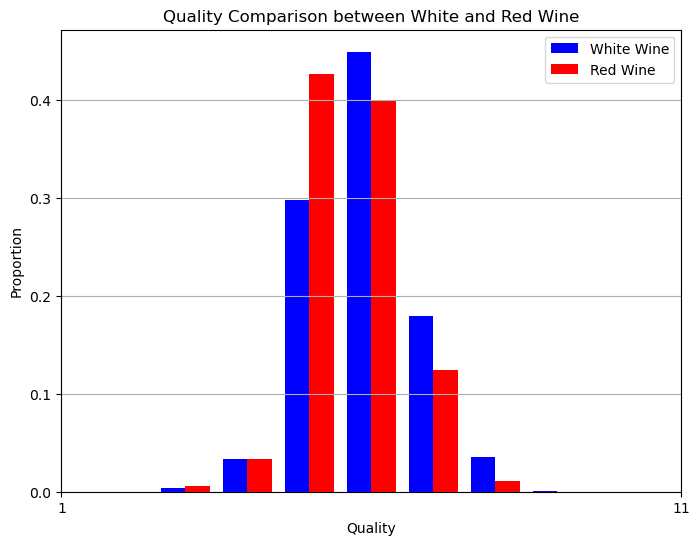

In [ ]:
# Extracting quality columns
white_quality = white_data['quality']
red_quality = red_data['quality']

# Get counts for each quality score
white_counts = white_quality.value_counts().sort_index()
red_counts = red_quality.value_counts().sort_index()

# Normalize counts to proportions
white_proportions = white_counts / white_counts.sum()
red_proportions = red_counts / red_counts.sum()

# Plotting bar chart
plt.figure(figsize=(8, 6))
plt.bar(white_proportions.index - 0.2, white_proportions, width=0.4,
        color='blue',
        label='White Wine', align='center')
plt.bar(red_proportions.index + 0.2, red_proportions, width=0.4,
        color='red', label='Red Wine', align='center')
plt.xlabel('Quality')
plt.ylabel('Proportion')
plt.title('Quality Comparison between White and Red Wine')
plt.xticks((1, 11))
plt.legend()
plt.grid(True)
plt.show()

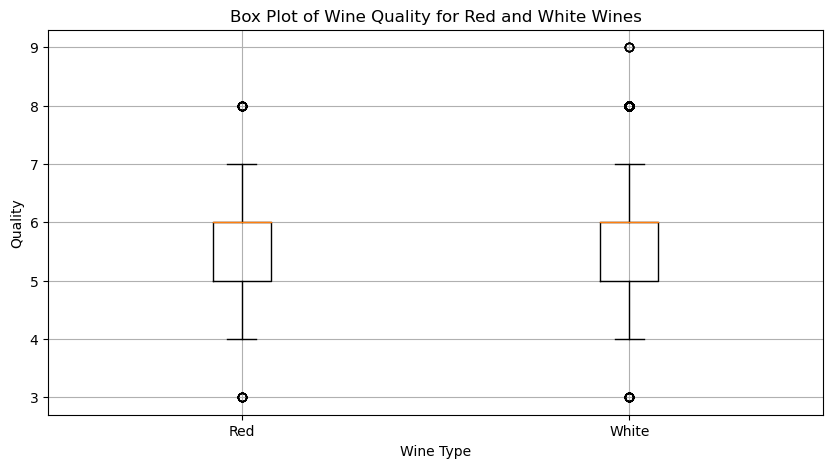

In [ ]:
# Plotting box plot
plt.figure(figsize=(10,5))
plt.boxplot([red_data['quality'], white_data['quality']], labels=['Red', 'White'])
plt.xlabel('Wine Type')
plt.ylabel('Quality')
plt.title('Box Plot of Wine Quality for Red and White Wines')
plt.grid(True)
plt.show()


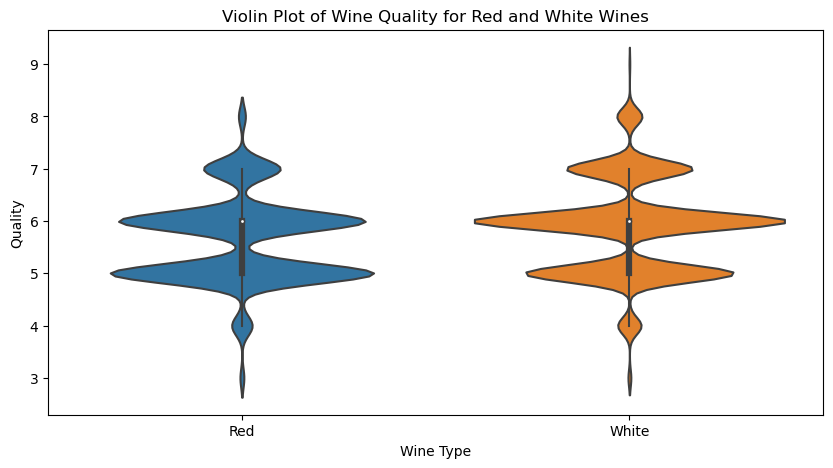

In [ ]:
#Plotting violin plot
plt.figure(figsize=(10,5))
sns.violinplot(data=[red_data['quality'], white_data['quality']])
plt.xticks([0, 1], ['Red', 'White'])
plt.xlabel('Wine Type')
plt.ylabel('Quality')
plt.title('Violin Plot of Wine Quality for Red and White Wines')
plt.show()


###Discretise Alcohol Content

The alcohol_cat variable:


*   low < (average - stddev)
*   (average - stddev) < mid < (average + stddev)
*   high > (average + stddev)


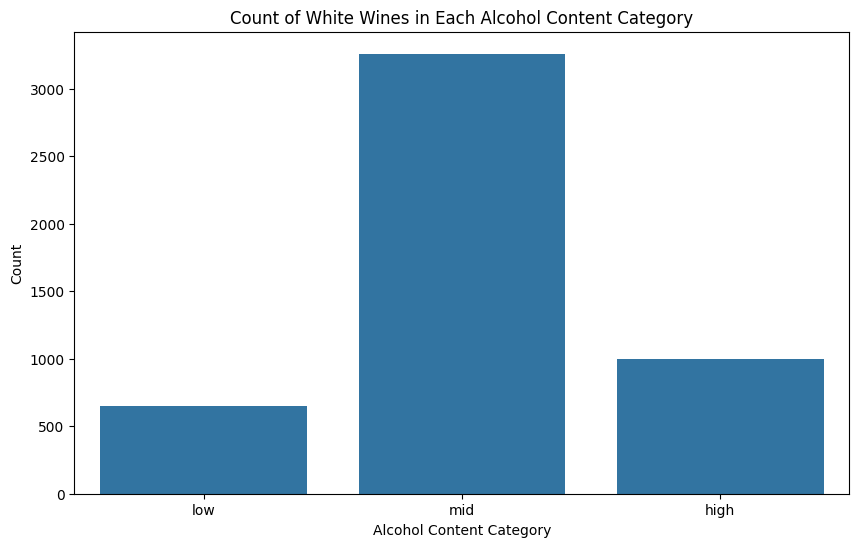

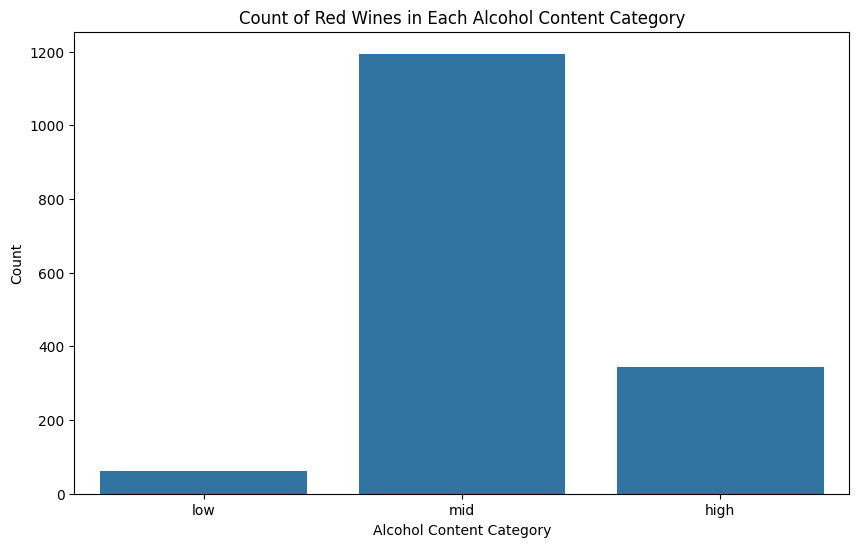

In [16]:
white_average_alc = white_data['alcohol'].median()
white_stddev = white_data['alcohol'].std()
red_average_alc = red_data['alcohol'].median()
red_stddev = red_data['alcohol'].std()

white_low_bound = white_average_alc - white_stddev
white_high_bound = white_average_alc + white_stddev

red_low_bound = red_average_alc - red_stddev
red_high_bound = red_average_alc + red_stddev

def categorize_alcohol_content(alcohol_content, low_bound, high_bound):
    if alcohol_content <= low_bound:
        return "low"
    elif alcohol_content > low_bound and alcohol_content <= high_bound:
        return "mid"
    else:
        return "high"

white_data['alcohol_cat'] = white_data['alcohol'].apply(lambda x:
                                                        categorize_alcohol_content(x, white_low_bound, white_high_bound))
red_data['alcohol_cat'] = red_data['alcohol'].apply(lambda x:
                                                    categorize_alcohol_content(x, red_low_bound, red_high_bound))

# Count the occurrences of each alcohol content category for white wines
white_alcohol_counts = white_data['alcohol_cat'].value_counts()

# Count the occurrences of each alcohol content category for red wines
red_alcohol_counts = red_data['alcohol_cat'].value_counts()

# Define the order of categories
order = ['low', 'mid', 'high']

# Plot the counts for white wines
plt.figure(figsize=(10, 6))
sns.barplot(x=white_alcohol_counts.index, y=white_alcohol_counts.values, order=order)
plt.title('Count of White Wines in Each Alcohol Content Category')
plt.xlabel('Alcohol Content Category')
plt.ylabel('Count')
plt.show()

# Plot the counts for red wines
plt.figure(figsize=(10, 6))
sns.barplot(x=red_alcohol_counts.index, y=red_alcohol_counts.values, order=order)
plt.title('Count of Red Wines in Each Alcohol Content Category')
plt.xlabel('Alcohol Content Category')
plt.ylabel('Count')
plt.show()


### Relationship Between Quality and Alcohol Content:

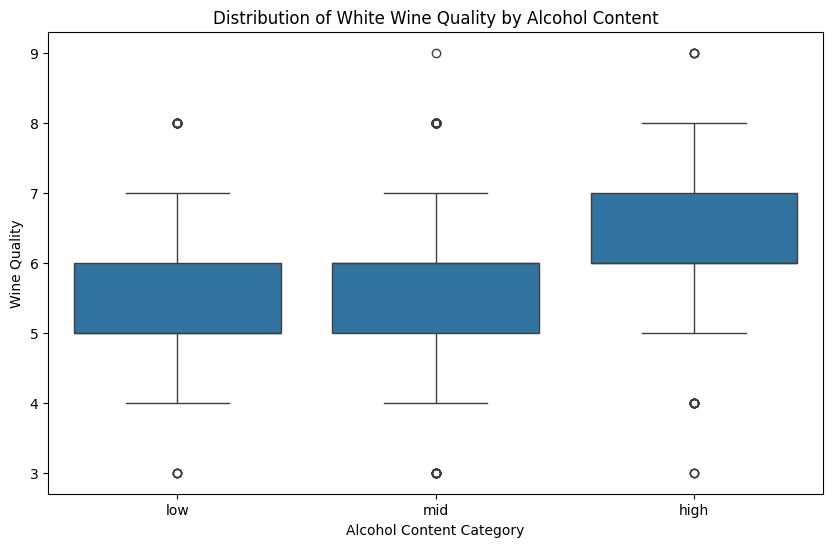

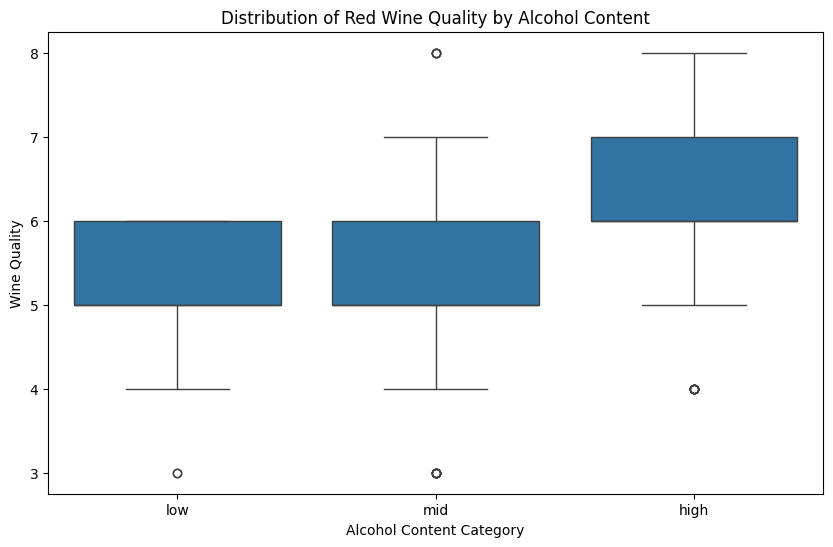

In [17]:
# Plot the distribution of wine quality for each alcohol content category
plt.figure(figsize=(10, 6))
sns.boxplot(x='alcohol_cat', y='quality', data=white_data, order=['low', 'mid', 'high'])
plt.title('Distribution of White Wine Quality by Alcohol Content')
plt.xlabel('Alcohol Content Category')
plt.ylabel('Wine Quality')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='alcohol_cat', y='quality', data=red_data, order=['low', 'mid', 'high'])
plt.title('Distribution of Red Wine Quality by Alcohol Content')
plt.xlabel('Alcohol Content Category')
plt.ylabel('Wine Quality')
plt.show()

### Combined relationship

Text(0, 0.5, 'Quality')

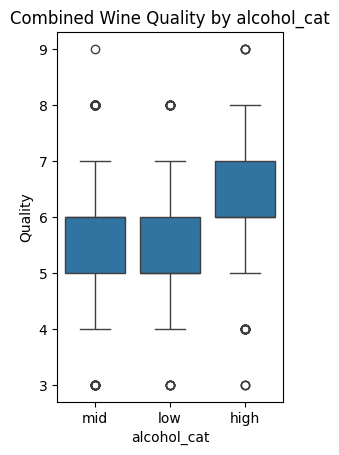

In [20]:
combined_data = pd.concat([red_data, white_data])
plt.subplot(1, 2, 2)
sns.boxplot(x='alcohol_cat', y='quality', data=combined_data)
plt.title('Combined Wine Quality by alcohol_cat')
plt.xlabel('alcohol_cat')
plt.ylabel('Quality')


### Discretise Residual Sugar Content

Threshold for sweet/dry classification in white wines: 5.2
Threshold for sweet/dry classification in red wines: 2.2


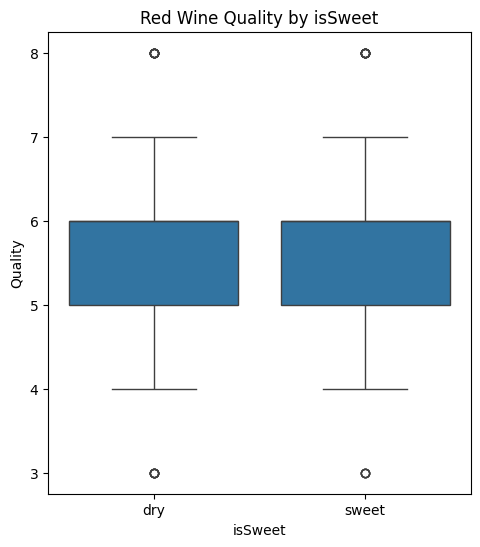

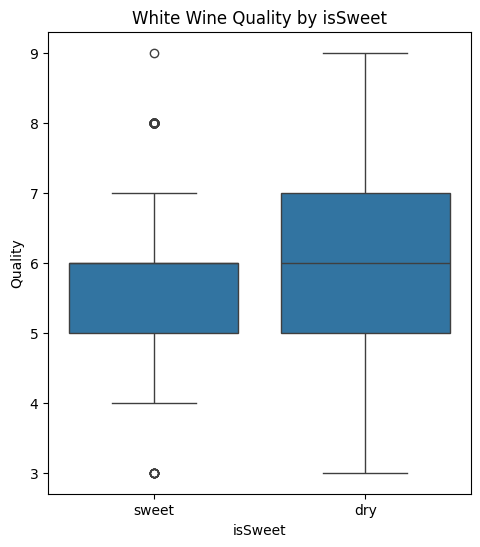

In [22]:
white_sugar = white_data['residual sugar'].sort_values()
red_sugar = red_data['residual sugar'].sort_values()
# Calculate the threshold index to split the dataset into roughly equal parts
white_split_index = len(white_sugar) // 2
red_split_index = len(red_sugar) // 2

# Find the threshold value
white_threshold = (white_sugar.iloc[white_split_index] + white_sugar.iloc[white_split_index - 1]) / 2
red_threshold = (red_sugar.iloc[red_split_index] + red_sugar.iloc[red_split_index - 1]) / 2

print("Threshold for sweet/dry classification in white wines:", white_threshold)
print("Threshold for sweet/dry classification in red wines:", red_threshold)

def categorize_sugar(sugar, threshold):
    if sugar < threshold:
        return "dry"
    else:
        return "sweet"

white_data['isSweet'] = white_data['residual sugar'].apply(lambda x: categorize_sugar(x, white_threshold))
red_data['isSweet'] = red_data['residual sugar'].apply(lambda x: categorize_sugar(x, red_threshold))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='isSweet', y='quality', data=red_data)
plt.title('Red Wine Quality by isSweet')
plt.xlabel('isSweet')
plt.ylabel('Quality')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='isSweet', y='quality', data=white_data)
plt.title('White Wine Quality by isSweet')
plt.xlabel('isSweet')
plt.ylabel('Quality')

plt.show()

### Relationship Between Quality and Residual Sugar:

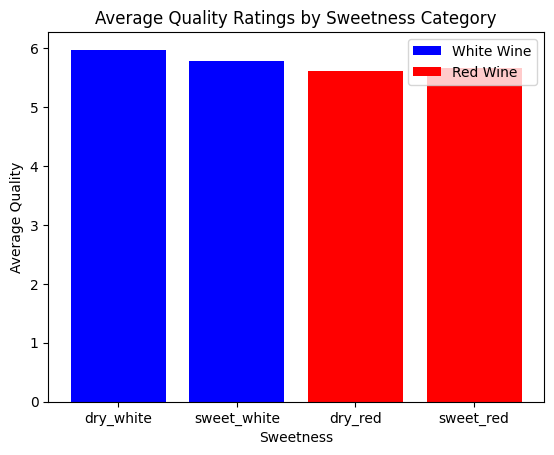

In [23]:
avg_quality_white = white_data.groupby('isSweet')['quality'].mean()

# Calculate the average quality ratings for each sweetness category for red wines
avg_quality_red = red_data.groupby('isSweet')['quality'].mean()

# Plotting the bar graph for white wines
plt.bar(avg_quality_white.index + "_white", avg_quality_white.values, color='blue', label='White Wine')

# Plotting the bar graph for red wines
plt.bar(avg_quality_red.index + "_red", avg_quality_red.values, color='red', label='Red Wine')

# Adding labels and title
plt.xlabel('Sweetness')
plt.ylabel('Average Quality')
plt.title('Average Quality Ratings by Sweetness Category')
plt.legend()

# Display the plot
plt.show()


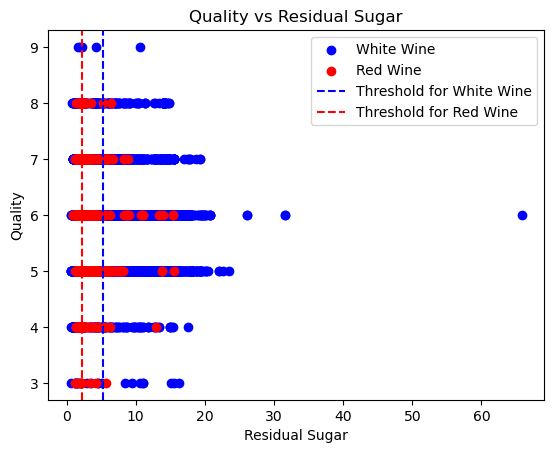

In [ ]:
# Scatter plot for white wines
plt.scatter(white_data['residual sugar'], white_data['quality'], color='blue', label='White Wine')

# Scatter plot for red wines
plt.scatter(red_data['residual sugar'], red_data['quality'], color='red', label='Red Wine')


plt.axvline(x=white_threshold, color='blue', linestyle='--', label='Threshold for White Wine')
plt.axvline(x=red_threshold, color='red', linestyle='--', label='Threshold for Red Wine')

# Adding labels and title
plt.xlabel('Residual Sugar')
plt.ylabel('Quality')
plt.title('Quality vs Residual Sugar')
plt.legend()

# Display the plot
plt.show()

### Combined Relationship

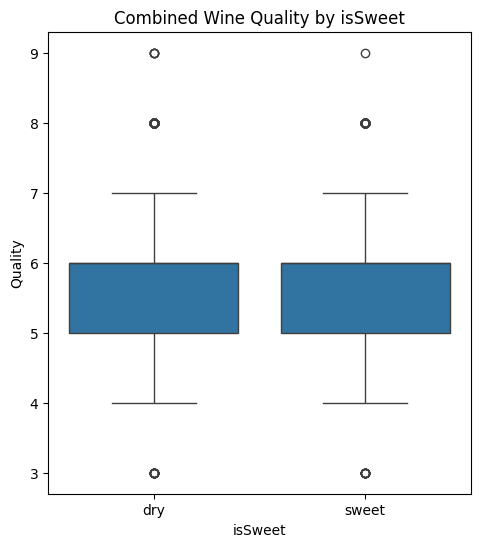

In [25]:
combined_data = pd.concat([red_data, white_data])

# Plotting quality distribution for isSweet and alcohol_cat variables for combined data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='isSweet', y='quality', data=combined_data)
plt.title('Combined Wine Quality by isSweet')
plt.xlabel('isSweet')
plt.ylabel('Quality')
plt.show()


### Variable Correlation:

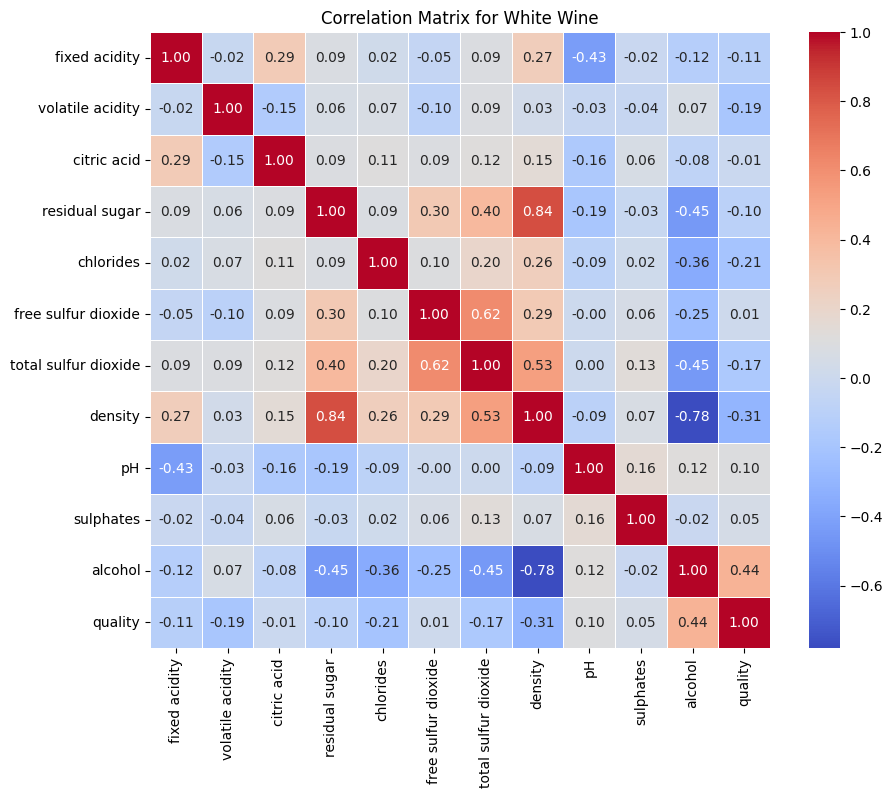

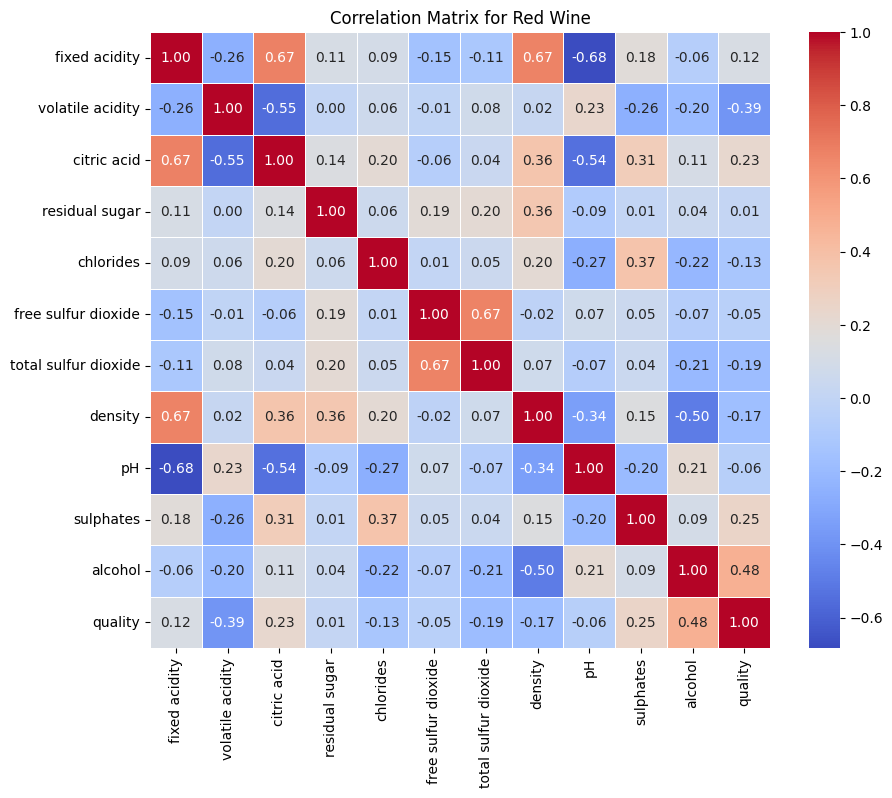

In [9]:
white_data = pd.read_csv('winequality-white.csv', delimiter=';')
red_data = pd.read_csv('winequality-red.csv', delimiter=';')

# Calculate correlation matrix for white wine data
white_corr = white_data.corr()

# Calculate correlation matrix for red wine data
red_corr = red_data.corr()

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(white_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for White Wine')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(red_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix for Red Wine')
plt.show()

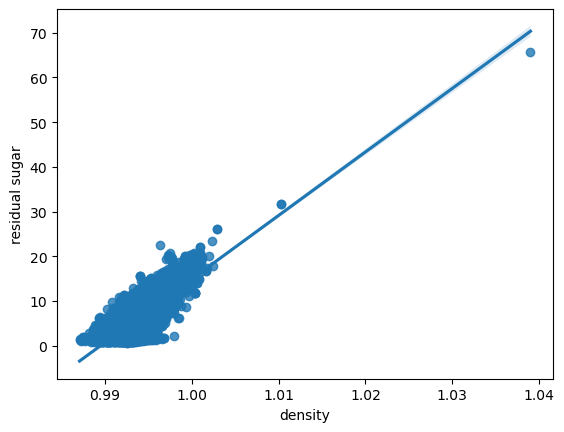

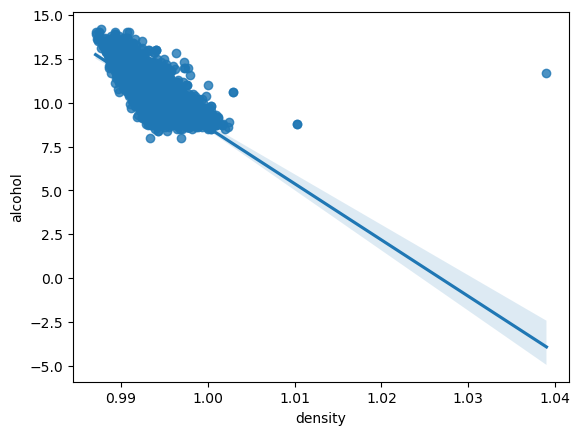

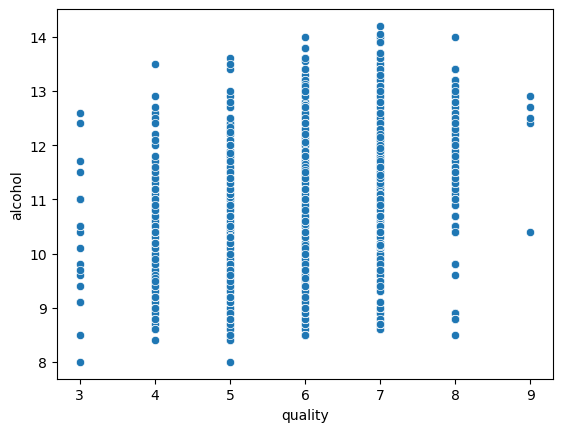

In [ ]:
sns.regplot(data=white_data, x="density", y="residual sugar").set
plt.show()
plt.close()

sns.regplot(data=white_data, x="density", y="alcohol").set
plt.show()
plt.close()

sns.scatterplot(data=white_data, x="quality", y="alcohol").set
plt.show()
plt.close()

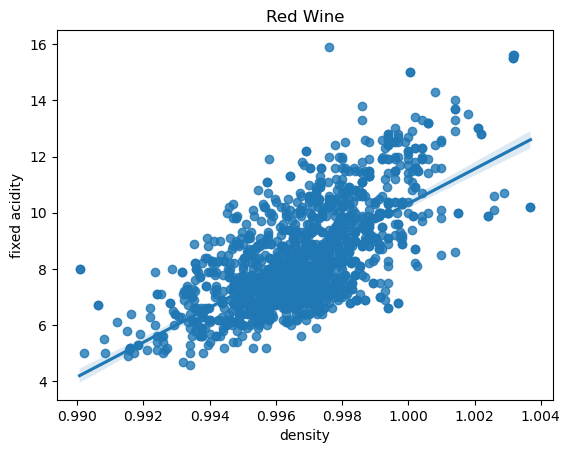

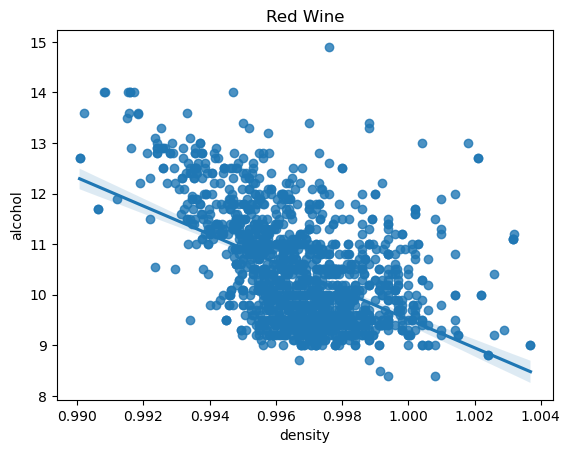

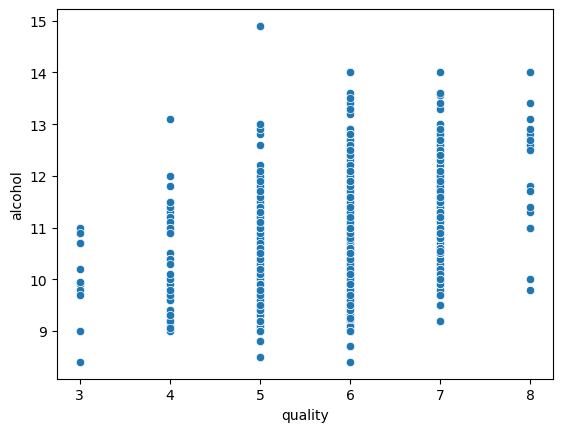

In [ ]:
sns.regplot(data=red_data, x="density", y="fixed acidity").set(title = "Red Wine")
plt.show()
plt.close()

sns.regplot(data=red_data, x="density", y="alcohol").set(title = "Red Wine")
plt.show()
plt.close()

sns.scatterplot(data=red_data, x="quality", y="alcohol").set
plt.show()
plt.close()

### Machine Learning Development:

### Classification

In [13]:
def preprocess_data(data):
    quality_binary = np.where(data['quality'] >= 6, 1, 0)
    X = data.drop('quality', axis=1)
    return X, quality_binary

def model_training(X, y, model_type='LogisticRegression', threshold=0.5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model_type == 'LogisticRegression':
        model = LogisticRegression()
    elif model_type == 'RandomForest':
        model = RandomForestClassifier()
    elif model_type == 'GradientBoosting':
        model = GradientBoostingClassifier()

    # Calculate class weights for red wine data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit and transform red wine training data
    scaler.fit(X_train)
    data_train_scaled = scaler.transform(X_train)
    data_test_scaled = scaler.transform(X_test)

    model.fit(data_train_scaled, y_train)  # Pass y_train here
    y_pred = model.predict(data_test_scaled)  # Predict on test data
    y_pred_train = model.predict(data_train_scaled)

    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score
    }

    results = {}
    for metric_name, metric_func in metrics.items():
        result = metric_func(y_test, y_pred)
        results[metric_name] = result
        print(f'{metric_name.capitalize()}: {result:.2f}')

    train_accuracy = accuracy_score(y_train, y_pred_train)
    results['train_accuracy'] = train_accuracy
    print(f'Training Accuracy: {train_accuracy:.2f}')

    test_accuracy = accuracy_score(y_test, y_pred)
    results['test_accuracy'] = test_accuracy
    print(f'Test Accuracy: {test_accuracy:.2f}')

    # Evaluate with threshold
    y_pred_prob = model.predict_proba(data_test_scaled)[:, 1]  # Predict probabilities on test data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return results

white_data = pd.read_csv('winequality-white.csv', delimiter=';')
red_data = pd.read_csv('winequality-red.csv', delimiter=';')
red_df = pd.DataFrame(red_data)
white_df = pd.DataFrame(white_data)

data_red_prep = red_df.drop(["residual sugar", "free sulfur dioxide", 'pH'], axis=1)
data_white_prep = white_df.drop(["residual sugar", "free sulfur dioxide", 'citric acid'], axis=1)

White - Logistical Regression:
Accuracy: 0.75
Precision: 0.78
Recall: 0.88
F1: 0.83
Training Accuracy: 0.76
Test Accuracy: 0.75


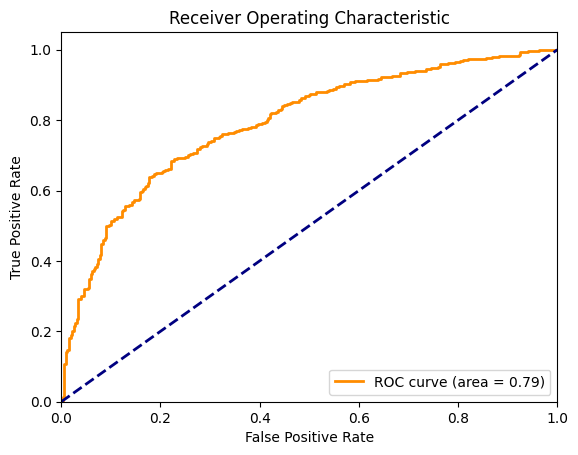


Red - Logistical Regression:
Accuracy: 0.74
Precision: 0.79
Recall: 0.74
F1: 0.76
Training Accuracy: 0.75
Test Accuracy: 0.74


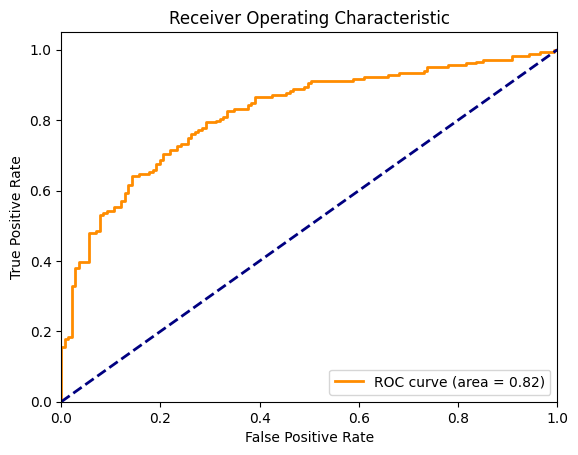

In [14]:
print("White - Logistical Regression:")
X_white, y_white = preprocess_data(white_data)
results_white = model_training(X_white, y_white, model_type='LogisticRegression', threshold=0.7)

print("\nRed - Logistical Regression:")
X_red, y_red = preprocess_data(red_data)
results_red = model_training(X_red, y_red, model_type='LogisticRegression', threshold=0.7)

In [ ]:
print("\nWhite - Random Forest:")
results_rf = model_training(X_white, y_white, model_type='RandomForest', threshold=0.7)

print("\nRed - Random Forest:")
results_rf = model_training(X_red, y_red, model_type='RandomForest', threshold=0.7)


White - Random Forest:
Metrics for each fold:
Accuracy: 0.84
Precision: 0.86
Recall: 0.91
F1: 0.88

Red - Random Forest:
Metrics for each fold:
Accuracy: 0.80
Precision: 0.82
Recall: 0.81
F1: 0.81


In [ ]:
print("\nWhite - Gradient Boosting:")
results_gb = model_training(X_white, y_white, model_type='GradientBoosting', threshold=0.7)

print("\nRed - Gradient Boosting:")
results_gb = model_training(X_red, y_red, model_type='GradientBoosting', threshold=0.7)



White - Gradient Boosting:
Metrics for each fold:
Accuracy: 0.78
Precision: 0.81
Recall: 0.88
F1: 0.84

Red - Gradient Boosting:
Metrics for each fold:
Accuracy: 0.77
Precision: 0.78
Recall: 0.78
F1: 0.78


### Regression

In [ ]:
def preprocess_data(data):
    X = data.drop('quality', axis=1)
    y = data['quality']
    return X, y

def model_training(X, y, model_type='LinearRegression'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if model_type == 'LinearRegression':
        model = LinearRegression()
    elif model_type == 'RandomForest':
        model = RandomForestRegressor()
    elif model_type == 'GradientBoosting':
        model = GradientBoostingRegressor()

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit and transform training data
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model.fit(X_train_scaled, y_train)  # Train the model
    y_pred_train = model.predict(X_train_scaled)  # Predict on train data
    y_pred_test = model.predict(X_test_scaled)

    metrics = {
        'Mean Squared Error': mean_squared_error,
        'Mean Absolute Error': mean_absolute_error,
        'R^2 Score': r2_score
    }

    results = {}
    for metric_name, metric_func in metrics.items():
        train_result = metric_func(y_train, y_pred_train)
        test_result = metric_func(y_test, y_pred_test)
        results[f'Train {metric_name}'] = train_result
        results[f'Test {metric_name}'] = test_result
        print(f'Train {metric_name}: {train_result:.2f}')
        print(f'Test {metric_name}: {test_result:.2f}')
    return results

white_data = pd.read_csv('winequality-white.csv', delimiter=';')
red_data = pd.read_csv('winequality-red.csv', delimiter=';')

print("White - Linear Regression:")
X_white, y_white = preprocess_data(white_data)
results_white = model_training(X_white, y_white, model_type='LinearRegression')

print("\nRed - Linear Regression:")
X_red, y_red = preprocess_data(red_data)
results_red = model_training(X_red, y_red, model_type='LinearRegression')

print("\nWhite - Random Forest Regressor:")
results_rf = model_training(X_white, y_white, model_type='RandomForest')

print("\nRed - Random Forest Regressor:")
results_rf = model_training(X_red, y_red, model_type='RandomForest')

print("\nWhite - Gradient Boosting Regressor:")
results_gb = model_training(X_white, y_white, model_type='GradientBoosting')

print("\nRed - Gradient Boosting Regressor:")
results_gb = model_training(X_red, y_red, model_type='GradientBoosting')


White - Linear Regression:
Train Mean Squared Error: 0.56
Test Mean Squared Error: 0.57
Train Mean Absolute Error: 0.58
Test Mean Absolute Error: 0.59
Train R^2 Score: 0.28
Test R^2 Score: 0.27

Red - Linear Regression:
Train Mean Squared Error: 0.42
Test Mean Squared Error: 0.39
Train Mean Absolute Error: 0.50
Test Mean Absolute Error: 0.50
Train R^2 Score: 0.35
Test R^2 Score: 0.40

White - Random Forest Regressor:
Train Mean Squared Error: 0.05
Test Mean Squared Error: 0.34
Train Mean Absolute Error: 0.16
Test Mean Absolute Error: 0.42
Train R^2 Score: 0.93
Test R^2 Score: 0.56

Red - Random Forest Regressor:
Train Mean Squared Error: 0.05
Test Mean Squared Error: 0.32
Train Mean Absolute Error: 0.16
Test Mean Absolute Error: 0.43
Train R^2 Score: 0.92
Test R^2 Score: 0.52

White - Gradient Boosting Regressor:
Train Mean Squared Error: 0.40
Test Mean Squared Error: 0.46
Train Mean Absolute Error: 0.50
Test Mean Absolute Error: 0.54
Train R^2 Score: 0.49
Test R^2 Score: 0.40

Red - G

### Final Model

In [ ]:
# Function to preprocess the data by converting quality into a binary label
def preprocess_data(data):
    quality_binary = np.where(data['quality'] >= 6, 1, 0)  # Convert quality into binary label
                                                           #(1 for quality >= 6, 0 otherwise)
    X = data.drop('quality', axis=1)  # Remove the 'quality' column to create features
    return X, quality_binary

# Function to build the final model, evaluate its performance, and visualize the ROC curve
def final_model(X, y, threshold=0.7):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize a Random Forest classifier
    model = RandomForestClassifier()

    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit and transform training data using StandardScaler
    scaler.fit(X_train)
    data_train_scaled = scaler.transform(X_train)
    data_test_scaled = scaler.transform(X_test)

    # Train the model on scaled training data
    model.fit(data_train_scaled, y_train)

    # Predict labels for test data
    y_pred = model.predict(data_test_scaled)
    y_pred_train = model.predict(data_train_scaled)

    # Calculate evaluation metrics
    metrics = {
        'accuracy': accuracy_score,
        'precision': precision_score,
        'recall': recall_score,
        'f1': f1_score
    }

    results = {}
    # Evaluate model performance using various metrics
    for metric_name, metric_func in metrics.items():
        result = metric_func(y_test, y_pred)
        results[metric_name] = result
        print(f'{metric_name.capitalize()}: {result:.2f}')

    # Calculate and print training accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    results['train_accuracy'] = train_accuracy
    print(f'Training Accuracy: {train_accuracy:.2f}')

    # Calculate and print test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    results['test_accuracy'] = test_accuracy
    print(f'Test Accuracy: {test_accuracy:.2f}')

    # Evaluate model using ROC curve and plot it
    y_pred_prob = model.predict_proba(data_test_scaled)[:, 1]  # Predict probabilities on test data
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)  # Calculate Area Under the ROC Curve (AUC)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return results

# Load white and red wine datasets
white_data = pd.read_csv('winequality-white.csv', delimiter=';')
red_data = pd.read_csv('winequality-red.csv', delimiter=';')

# Preprocess white and red wine data separately
data_red_prep = red_data.drop(["residual sugar", "free sulfur dioxide", 'pH'], axis=1)
data_white_prep = white_data.drop(["residual sugar", "free sulfur dioxide", 'citric acid'], axis=1)

# Get features and labels for white and red wine datasets
X_white, y_white = preprocess_data(data_white_prep)
X_red, y_red = preprocess_data(data_red_prep)

# Train and evaluate the final model for white wine dataset
print("\nWhite")
results_rf_white = final_model(X_white, y_white)

# Train and evaluate the final model for red wine dataset
print("\nRed")
results_rf_red = final_model(X_red, y_red)
